# Get Lightglue running

In [1]:
from lightglue import LightGlue, SuperPoint, DISK 
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
from pathlib import Path

torch.set_grad_enabled(False)
images = Path("../temp_downloads/Hierarchical-Localization-master/datasets/sacre_coeur/mapping")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

In [ ]:
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

In [3]:
# Set image pairs
image0 = load_image(images / "02928139_3448003521.jpg")
image1 = load_image(images / "17295357_9106075285.jpg")

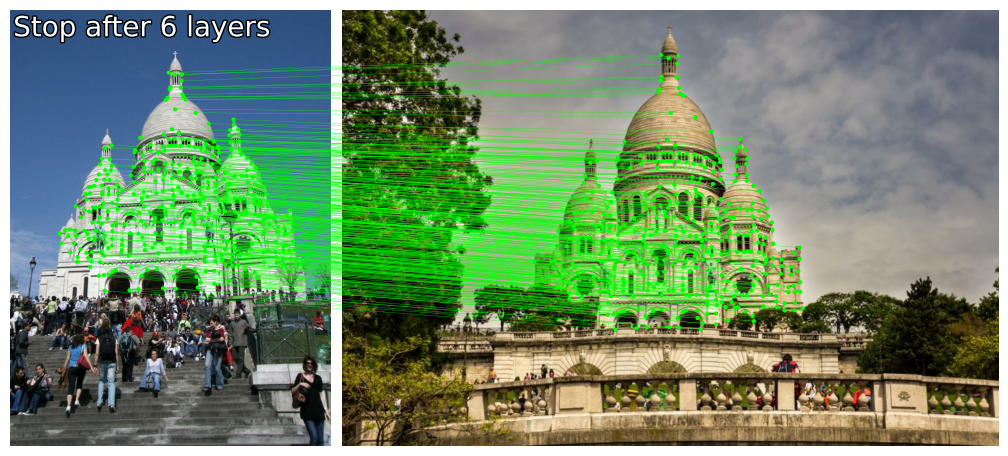

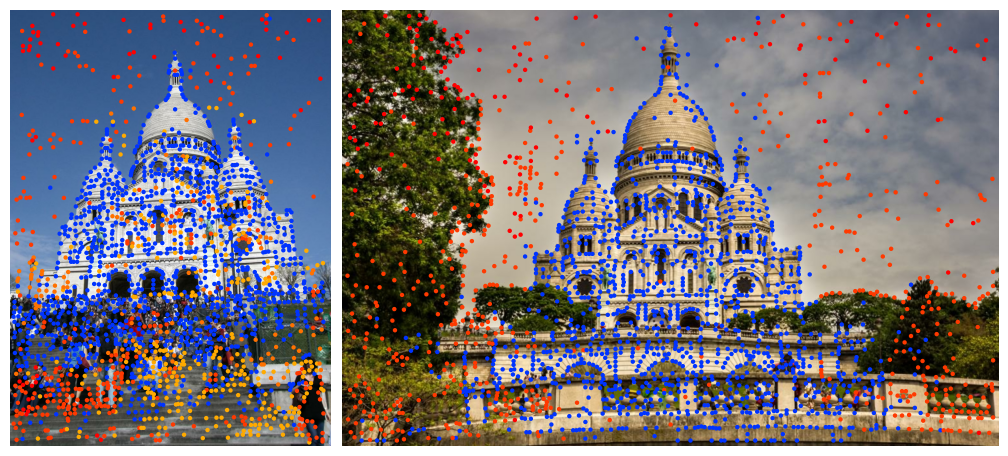

In [4]:
# Run lightglue for matching and visulize the results
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

# Run Hierarchical-Localization

Save 3D cloud points

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
    pairs_from_exhaustive
)
from hloc.utils import viz_3d

In [3]:
# images = Path("/Users/gujia/Hierarchical-Localization/datasets/South-Building/images/")
images = Path("datasets/sacre_coeur")
outputs = Path("outputs/sfm_disk+lightglue")
sfm_dir = outputs / "sfm"
sfm_pairs = outputs / "pairs-sfm.txt"
loc_pairs = outputs / "pairs-loc.txt"
features = outputs / "features.h5"
matches = outputs / "matches.h5"

# retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["disk"]
matcher_conf = match_features.confs["disk+lightglue"]

references = [p.relative_to(images).as_posix() for p in (images / "mapping/").iterdir()]

In [4]:
feature_path = extract_features.main(
    feature_conf, images, image_list=references, feature_path=features
)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_path = match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

[2025/11/26 12:05:41 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
[2025/11/26 12:05:41 hloc INFO] Skipping the extraction.
[2025/11/26 12:05:41 hloc INFO] Found 45 pairs.
[2025/11/26 12:05:41 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
[2025/11/26 12:05:41 hloc INFO] Skipping the matching.


In [5]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

[2025/11/26 12:05:44 hloc INFO] Writing COLMAP logs to outputs/sfm_disk+lightglue/sfm/colmap.LOG.*


[2025/11/26 12:05:44 hloc WARNING] The database already exists, deleting it.
[2025/11/26 12:05:44 hloc INFO] Creating an empty database...
[2025/11/26 12:05:44 hloc INFO] Importing images into the database...
[2025/11/26 12:05:44 hloc INFO] Importing features into the database...
100%|██████████| 10/10 [00:00<00:00, 581.51it/s]
[2025/11/26 12:05:44 hloc INFO] Importing matches into the database...
100%|██████████| 45/45 [00:00<00:00, 683.72it/s]
[2025/11/26 12:05:44 hloc INFO] Performing geometric verification of the matches...
[2025/11/26 12:05:45 hloc INFO] Running 3D reconstruction...
Reconstruction 0: 100%|██████████| 10/10 [00:17<00:00,  1.72s/images, registered]
[2025/11/26 12:06:03 hloc INFO] Reconstructed 1 model(s).
[2025/11/26 12:06:03 hloc INFO] Largest model is #0 with 10 images.
[2025/11/26 12:06:03 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_rigs = 10
	num_cameras = 10
	num_frames = 10
	num_reg_frames = 10
	num_images = 10
	num_points3D = 5898
	num_observat

In [6]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(
    fig, model, color="rgba(255,0,0,0.5)", name="mapping", points_rgb=True
)
fig.show()

In [7]:
# Save the obtained 3D clouds
import numpy as np
model.export_PLY('3d_cloud_set/sacre_coeur_my_reconstruction.ply')
np.save('3d_cloud_set/sacre_coeur_3d.npy', np.array([p.xyz for p in model.points3D.values()]))
np.save('3d_cloud_set/sacre_coeur_3d_colored.npy', np.array([p.color for p in model.points3D.values()]))

In [8]:
query = "query/night.jpg"
extract_features.main(
    feature_conf, images, image_list=[query], feature_path=features, overwrite=True
)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(
    matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True
)

[2025/10/17 20:02:23 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
[2025/10/17 20:02:24 hloc INFO] Finished exporting features.
[2025/10/17 20:02:24 hloc INFO] Found 10 pairs.
[2025/10/17 20:02:24 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
100%|██████████| 10/10 [00:24<00:00,  2.49s/it]
[2025/10/17 20:02:49 hloc INFO] Finished exporting matches.


PosixPath('outputs/sfm_disk+lightglue/matches.h5')

found 3119/4624 inlier correspondences.


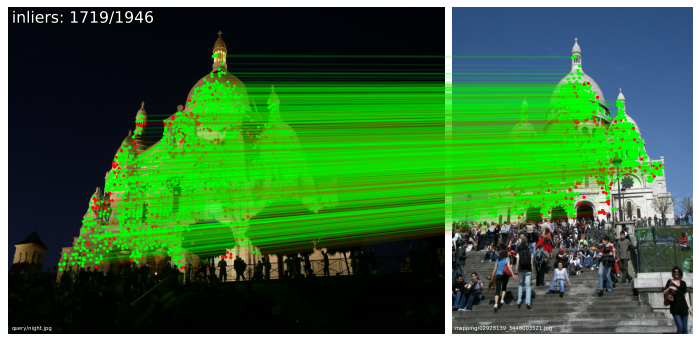

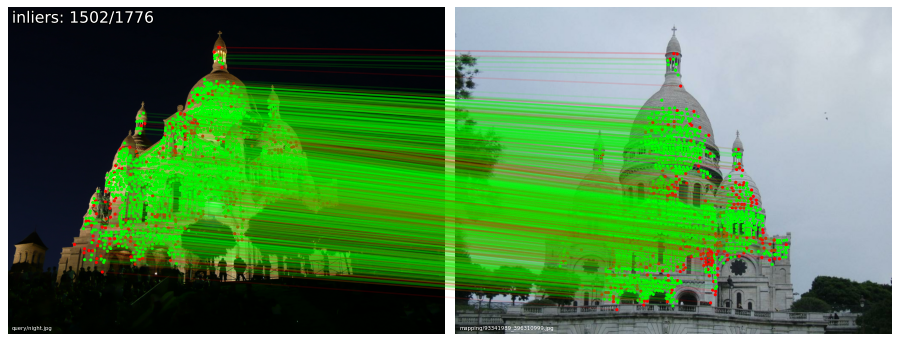

In [9]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    "estimation": {"ransac": {"max_error": 12}},
    "refinement": {"refine_focal_length": True, "refine_extra_params": True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inlier_mask"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

In [10]:
import pickle
with open('3d_cloud_set/query_camera.pkl', 'wb') as f:
    pickle.dump((ret["camera"], ret["cam_from_world"]), f)

# Save 3D-2D correspondences
Define a dictionary "matches_3d_2d" contains the corresponding 2D observations, including image id and 2D coordinates for each 3D cloud point.

In [ ]:
from hloc.utils import read_write_model as rw

cameras, images, points3D = rw.read_model("outputs/sfm_disk+lightglue/sfm", ext=".bin")
matches_3d_2d = {}
for point_id, point in points3D.items():
    matches_3d_2d[point_id] = {
        'point_3d': point.xyz,  # 3D coordinates
        'observations': []      # List of (image_id, point2D_idx) tuples
    }
    matches_3d_2d[point_id]['observations'] =[
        (img_id, point2D_idx) for img_id, point2D_idx in zip(point.image_ids, point.point2D_idxs)
    ] # 2D coordinates: images[img_id].xys[point2D_idx]
matches_3d_2d


{3: {'point_3d': array([-0.83519886,  0.54209424,  5.49765466]),
  'observations': [(8, 652),
   (10, 1145),
   (5, 420),
   (3, 354),
   (9, 938),
   (7, 1292),
   (4, 503),
   (6, 254)]},
 6: {'point_3d': array([-1.55633711,  0.70341459,  6.04423883]),
  'observations': [(8, 463),
   (10, 1171),
   (2, 448),
   (5, 178),
   (3, 241),
   (9, 957),
   (1, 667),
   (7, 1339),
   (4, 522),
   (6, 450)]},
 7: {'point_3d': array([-1.53427215,  0.70098209,  6.05709996]),
  'observations': [(8, 472),
   (10, 1172),
   (5, 204),
   (3, 253),
   (9, 958),
   (1, 654),
   (7, 1346),
   (4, 523),
   (6, 444)]},
 8: {'point_3d': array([-0.81837439,  0.5504105 ,  5.51421469]),
  'observations': [(8, 698),
   (10, 1174),
   (2, 24),
   (3, 376),
   (9, 954),
   (1, 435),
   (6, 258)]},
 9: {'point_3d': array([-1.57570726,  0.70510884,  6.0572819 ]),
  'observations': [(8, 451), (10, 1179), (3, 232)]},
 10: {'point_3d': array([-1.51278623,  0.70200459,  6.04774459]),
  'observations': [(8, 486), (10

In [67]:
import pickle
with open('3d_cloud_set/3D_2D_correspondences_disk.txt', 'wb') as f:
    pickle.dump(matches_3d_2d, f)

## ===================Start From Here==================
If you have already run the above cells before or have all the required files download, including reconstructed 3D points, 3d_2d_correspondences, estimated cameras, .bin model files, you can start here directly.

# Get 3D feature representations
Here we take the mean value of features extracted from the corresponding 2D points as a representation of each 3D cloud point

In [24]:
import pickle
with open('3d_cloud_set/3D_2D_correspondences_disk.txt', 'rb') as f:
    matches_3d_2d = pickle.load(f)

In [25]:
from lightglue import LightGlue, SuperPoint, DISK 
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
from pathlib import Path
import numpy  as np
from tqdm import tqdm

from hloc.utils import read_write_model as rw
cameras, images, points3D = rw.read_model("outputs/sfm_disk+lightglue/sfm", ext=".bin")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
extractor = DISK(max_num_keypoints=5000).eval().to(device)  # load the extractor
matcher = LightGlue(features="disk").eval().to(device)

images_dir = Path("datasets/sacre_coeur")

extract and cache the features of reference imgaes

In [26]:
descriptor_dim = 128 # 256 for superpoint, 128 for disk
point_features = {}
image_cache = {}

image_id_to_name = {}
for img_id, img_data in images.items():
    image_id_to_name[img_id] = img_data.name 

all_image_ids = set()
for point_id, point_data in matches_3d_2d.items():
    for img_id, _ in  point_data['observations']:
        all_image_ids.add(img_id)
print(f"{len(all_image_ids)} images to process in total")

print("Pre-loading image features...")
for img_id in tqdm(all_image_ids):
    img_path = images_dir / f"{image_id_to_name[img_id]}" 
    if not img_path.exists():
        print(f"Error: Image {img_id} does not exist")
        continue
    try:
        image = load_image(img_path).to(device)
        with torch.no_grad():
            feats = extractor.extract(image)
        image_cache[img_id] = {
            'keypoints': feats['keypoints'].cpu().numpy(),                
            'descriptors': feats['descriptors'].cpu().numpy(),
            'scores': feats['keypoint_scores'].cpu().numpy(),
            'size' : feats['image_size'].cpu().numpy()
        }
    except Exception as e:
        print(f"Error occured when processing image {img_id}: {e}")
        continue



10 images to process in total
Pre-loading image features...


100%|██████████| 10/10 [00:01<00:00,  8.88it/s]


In [27]:
print("Computing averaged features for 3D points...")
for point_id, point_data in tqdm(matches_3d_2d.items()):
    descriptors_list, scores_list = [], []
    for img_id, point2D_idx in point_data['observations']:
        if img_id not in image_cache:
            continue
                
        feats = image_cache[img_id]
        keypoints = feats['keypoints']
        descriptors = feats['descriptors']
        scores = feats['scores']
        if len(keypoints) == 0:
            continue

        if keypoints.ndim == 3 and keypoints.shape[0] == 1:
            keypoints = keypoints[0]
        if descriptors.ndim == 3 and descriptors.shape[0] == 1:
            descriptors = descriptors[0]
        if scores.ndim == 2 and scores.shape[0] == 1:
            scores = scores[0]
        
        actual_coord = images[img_id].xys[point2D_idx]
        distances = np.linalg.norm(keypoints - actual_coord, axis=1)
        closest_idx = np.argmin(distances)
       
        if np.min(distances) < 1.0 and closest_idx < len(distances):  # Pixels, adjustable threshold
            descriptors_list.append(descriptors[closest_idx])
            scores_list.append(scores[closest_idx])
                
    if descriptors_list:
        avg_descriptor = np.mean(descriptors_list, axis=0)
        avg_score = np.mean(scores_list, axis=0)
        point_features[point_id] = {
            'descriptor': avg_descriptor,
            'keypoint_scores' : avg_score,
            'num_observations': len(descriptors_list),
            'point_3d': points3D[point_id].xyz if point_id in points3D else None
        }
    else:
        point_features[point_id] = {
            'descriptor': np.zeros(descriptor_dim),
            'keypoint_scores' : 0,
            'num_observations': 0,
            'point_3d': points3D[point_id].xyz if point_id in points3D else None
        }

Computing averaged features for 3D points...


100%|██████████| 5898/5898 [00:08<00:00, 713.39it/s] 


In [28]:
ref_img = [ i['num_observations'] for _, i in point_features.items()]
ref_real = [ k for k in ref_img if k!= 0]

print(f"{len(ref_real)} of {len(ref_img)} 3D points get references")

5717 of 5898 3D points get references


In [29]:
point_features

{3: {'descriptor': array([-0.05817935,  0.05124627, -0.02308275, -0.01087631, -0.09347367,
         -0.09762438,  0.01440533, -0.00488437,  0.07034222, -0.00391607,
         -0.11616177,  0.01135727, -0.00756599,  0.08992527, -0.04227226,
          0.08131313,  0.01931479,  0.01140891, -0.06101569, -0.00047039,
          0.06966207,  0.01930096, -0.00070138,  0.04659262, -0.02118172,
          0.00304617,  0.00924555, -0.01360047, -0.09299138,  0.00664269,
          0.08083702, -0.07605521, -0.03529938,  0.00861612,  0.14095433,
          0.07397773,  0.00932215, -0.01801926,  0.0009686 , -0.04251322,
         -0.07196656, -0.0306196 , -0.03582321, -0.07378   ,  0.09318688,
          0.00879793,  0.04913852, -0.00836545,  0.09388372,  0.08480775,
          0.00370484,  0.01762684,  0.08002724, -0.03742899,  0.02352921,
         -0.03056279, -0.05410086, -0.12340959,  0.00275695, -0.06382611,
          0.01550498, -0.00892102,  0.01100872, -0.01358326,  0.01076884,
          0.05274798,

# Convert 3D representations to a lightglue-input format dictionary

In [52]:
# positional encoding: simply remove one axis, default z-axis
import numpy as np
def pos_encode(point_3d : np.array, scaler=10, exclude_axis='z', showplot=False):
    if exclude_axis=='z':
        points_2d = point_3d[:, :2] # take x, y corrdinates
    elif exclude_axis=='y':
        points_2d = np.stack((point_3d[:, 0], point_3d[:, -1]), axis=1) # take x, z corrdinates
    elif exclude_axis=='x':
        points_2d = point_3d[:, 1:] # take y, z corrdinates
    else:
        raise ValueError("exclude_axis must be 'x', 'y', or 'z'")
    x_min, y_min = np.min(points_2d, axis=0)
    x_max, y_max = np.max(points_2d, axis=0)
    image_width =  max(int((x_max - x_min) * scaler), 1)
    image_height =  max(int((y_max - y_min) * scaler), 1)

    def map_to_pixel(coords, min_val, max_val, size):
        """map every keypoints_2d(float) into a pixel"""
        if max_val - min_val < 1e-10: 
            return np.full(len(coords), size // 2)
        normalized = (coords - min_val) / (max_val - min_val)
        pixels = (normalized * (size - 1)).astype(int)
        return np.clip(pixels, 0, size - 1)
    
    pixel_x = map_to_pixel(points_2d[:, 0], x_min, x_max, image_width)
    pixel_y = map_to_pixel(points_2d[:, 1], y_min, y_max, image_height)
    keypoints_2d = np.column_stack((pixel_x, pixel_y))
    if showplot==True:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6, 4))
        plt.scatter(keypoints_2d[:, 0], keypoints_2d[:, 1], s=5, alpha=0.7, color='blue')
        # plt.tight_layout()
        plt.axis('equal')
        plt.show()
    return keypoints_2d, image_width, image_height

In [31]:
import torch
import numpy as np
import math

def convert_3d_features_to_lightglue_format(point_features : dict, scaler=10, device='cuda', 
                                            exclude_axis='z',showplot=False) -> dict:
    
    if not point_features:
        raise ValueError("Input 3D_features is empty")
    
    # extract 3D keypoints
    point_ids = list(point_features.keys())
    n_points = len(point_ids)
    
    # extract 3D coordinates, descriptors and scores
    points_3d = []
    descriptors = []
    scores = []
    
    for pid in point_ids:
        point_3d = point_features[pid]['point_3d'].flatten()
        # if point_3d[-1] <= 4.0: # not a generalized method, just to test how overlaps influence the results
        #     continue
        points_3d.append(point_3d)
        
        descriptor = point_features[pid]['descriptor'].flatten() 
        descriptors.append(descriptor)
        
        if point_features[pid]['keypoint_scores'] is not None:
            score = point_features[pid]['keypoint_scores']
        else:
            score = 1.0
        scores.append(score)
    
    points_3d = np.array(points_3d)        # (N, 3)
    descriptors = np.array(descriptors)    # (N, descriptor_dim)
    scores = np.array(scores)              # (N,)
    
    # convert 3D keypoints into an artificial image
    keypoints_2d, image_width, image_height = pos_encode(points_3d, scaler, exclude_axis=exclude_axis, 
                                                         showplot=showplot)
    
    # convert to torch.tensor format
    keypoints_tensor = torch.from_numpy(keypoints_2d).float().to(device).unsqueeze(0)      # (1, N, 2)
    descriptors_tensor = torch.from_numpy(descriptors).float().to(device).unsqueeze(0)     # (1, N, dim)
    scores_tensor = torch.from_numpy(scores).float().to(device).unsqueeze(0)              # (1, N)
    image_size_tensor = torch.tensor([image_width, image_height], dtype=torch.float).to(device).unsqueeze(0)  # (1, 2)
    
    lightglue_features = {
        'keypoints': keypoints_tensor,
        'descriptors': descriptors_tensor, 
        'keypoint_scores': scores_tensor,
        'image_size': image_size_tensor
    }
    
    print(f"Converted {n_points} 3D points to virtual image of size {image_width}x{image_height} with {len(points_3d)} filtered keypoints.")
    
    return lightglue_features


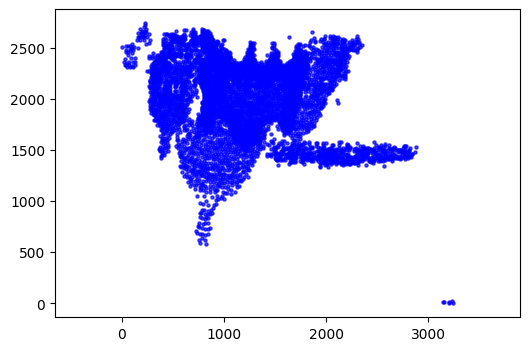

Converted 5898 3D points to virtual image of size 3242x2739 with 5898 filtered keypoints.


In [53]:
feat_3d = convert_3d_features_to_lightglue_format(point_features, scaler=1000, device = device, 
                                                  exclude_axis='z', showplot=True)

In [11]:
feat_3d

{'keypoints': tensor([[[1165., 1554.],
          [ 444., 1715.],
          [ 466., 1713.],
          ...,
          [1585., 2027.],
          [ 432., 2399.],
          [1370., 2247.]]], device='cuda:0'),
 'descriptors': tensor([[[-0.0582,  0.0512, -0.0231,  ...,  0.1004,  0.0663, -0.0374],
          [-0.0803,  0.0412, -0.0026,  ..., -0.0112,  0.0652, -0.0343],
          [-0.0503,  0.0269, -0.0568,  ...,  0.0075, -0.0610,  0.0188],
          ...,
          [-0.0995,  0.0391,  0.1022,  ..., -0.0034, -0.0166,  0.0994],
          [-0.1387,  0.0926, -0.0106,  ...,  0.0732, -0.0975, -0.0167],
          [ 0.0199, -0.0667, -0.0571,  ...,  0.0717, -0.1703,  0.0192]]],
        device='cuda:0'),
 'keypoint_scores': tensor([[59.4774, 47.3891, 48.7702,  ..., 70.3268, 35.4411, 57.8081]],
        device='cuda:0'),
 'image_size': tensor([[3242., 2739.]], device='cuda:0')}

# Match a query image with the 3D representation features in lightglue

In [12]:
query = load_image(Path(images_dir) / "query/night.jpg")
feats_q = extractor.extract(query.to(device))

In [13]:
matches01 = matcher({"image0": feat_3d, "image1": feats_q})
feats0, feats1, matches01 = [
    rbd(x) for x in [feat_3d, feats_q, matches01]
]

In [14]:
kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

point_ids = list(point_features.keys())
points_3d = np.array([point_features[pid]['point_3d'].flatten() for pid in point_ids])  # (N, 3)
match_indices = matches[:, 0].cpu().numpy() if torch.is_tensor(matches) else matches[:, 0]
matched_3d_coords = points_3d[match_indices]
print(f"{len(m_kpts0)} matched 3D points")

1886 matched 3D points


In [15]:
from hloc.utils import viz_3d
fig = viz_3d.init_figure()
viz_3d.plot_points(
    fig, points_3d, color="rgba(150,150,150,1)", name="3D model"
)
viz_3d.plot_points(fig, matched_3d_coords, color="lime", ps=1, name="matches")
fig.show()

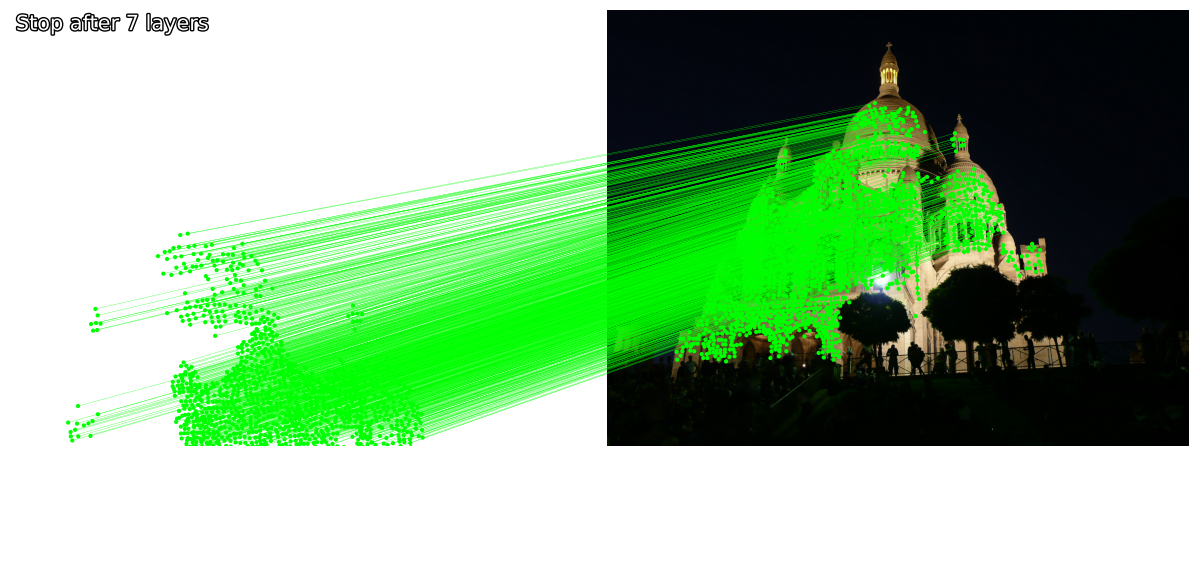

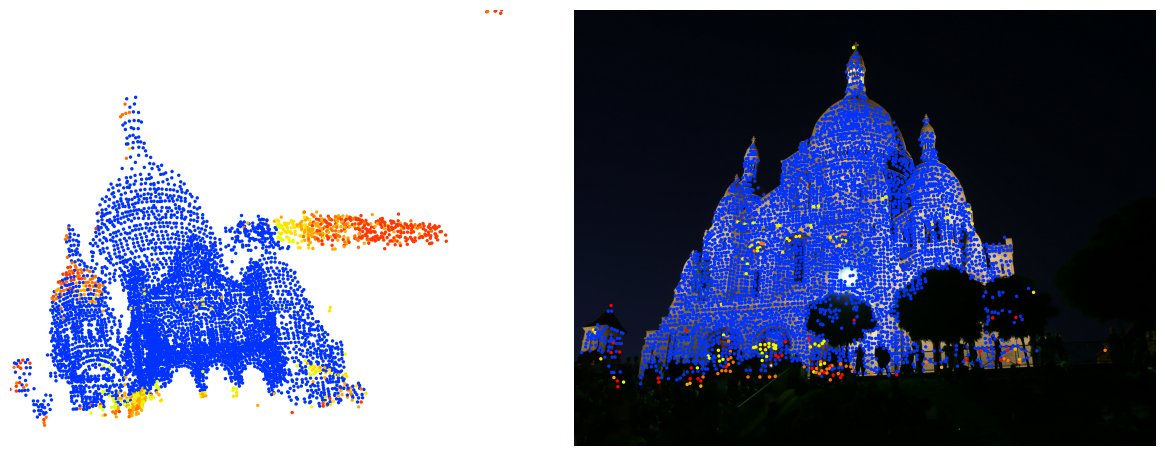

In [16]:
viz2d.plot_images([torch.ones_like(query), query])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([torch.ones_like(query), query])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

In [17]:
# numbers of matchable points (blue points)
num_match_3d = np.shape(np.where(kpc0[:, 2]==1))[1]
num_match_2d = np.shape(np.where(kpc1[:, 2]==1))[1]
print(f"{num_match_2d} matchable points found in the query image and {num_match_3d} found in the 3D cloud")

4841 matchable points found in the query image and 5079 found in the 3D cloud


In [18]:
# Pruning in the 3D view
fig = viz_3d.init_figure()
viz_3d.plot_points(
    fig, points_3d, color="rgba(150,150,150,0)", name="3D model"
)
viz_3d.plot_points(fig, points_3d, color=kpc0, ps=1, name="matches")
fig.show()

## Check the accuracy of matching results
Compare the matched pairs to the results obtained in hloc

In [19]:
def reproject_point_with_distortion(P, point_3d, camera_params):
    
    point_3d_homo = np.array([point_3d[0], point_3d[1], point_3d[2], 1.0])
    
    # projection and normalization
    point_camera = P @ point_3d_homo
    x_normalized = point_camera[0] / point_camera[2]
    y_normalized = point_camera[1] / point_camera[2]
    # apply radial distortion
    k = camera_params[3]
    r2 = x_normalized * x_normalized + y_normalized * y_normalized
    radial_distortion = 1.0 + k * r2
    point_distorted = [x_normalized * radial_distortion, y_normalized * radial_distortion]
    # compute pixel coordinates
    f, cx, cy, _ = camera_params
    u = f * point_distorted[0] + cx
    v = f * point_distorted[1] + cy
    
    return np.array([u, v])

In [20]:
import pickle
with open('3d_cloud_set/query_camera.pkl', 'rb') as f:
    camera_loaded = pickle.load(f)
inner_camera = camera_loaded[0]
extri_camera = camera_loaded[1]

In [21]:
# compute the extrinsic matrix
rotation_matrix = extri_camera.rotation.matrix() # R
translation = extri_camera.translation
P = np.hstack([rotation_matrix, np.array(translation).reshape(3, 1)]) # extrinsic matrix [R|t]

In [22]:
# check accuracy
matched_2d_coords = m_kpts1.cpu().numpy()
N = np.shape(matched_3d_coords)[0]
errors = []
th = 5.0
for i in range(N):
    proj_3d_to_2d = reproject_point_with_distortion(P, matched_3d_coords[i], inner_camera.params)
    error = np.linalg.norm(proj_3d_to_2d - matched_2d_coords[i])
    errors.append(error)
errors = np.array(errors)
qualified_matches = errors < th
qualified_pair_ids = np.where(qualified_matches == True)
print(f"Overall averaged reprojection error: {np.mean(errors):.4f}")
print(f"{np.shape(qualified_pair_ids)[-1]}/{N} matched pairs are accurate with reprojection error < {th}")

Overall averaged reprojection error: 8.3332
1084/1886 matched pairs are accurate with reprojection error < 5.0
